___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Авторские права принадлежат Pierian Data Inc.</em></center>
<center><em>Для дополнительной информации посетите наш сайт <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Метод К-ближайших соседей (KNN -  K Nearest Neighbors)

Метод К-ближайших соседей применяется для классификации данных. В этой лекции мы будем работать с набором данных об уровнях генов. Уровени генов вычисляются как отношение между уровнем целевого гена (изучаемый ген) и уровня одного или нескольких референсных генов (как правило, уже имеющихся генов). Этот набор данных является синтетическим, и он специально был создан для того, чтобы показать сильные и слабые стороны метода KNN для классификации.


Дополнительные сведения про гены можно почитать здесь: https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Данные

In [3]:
df = pd.read_csv('../DATA/gene_expression.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [4]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


<Axes: xlabel='Gene One', ylabel='Gene Two'>

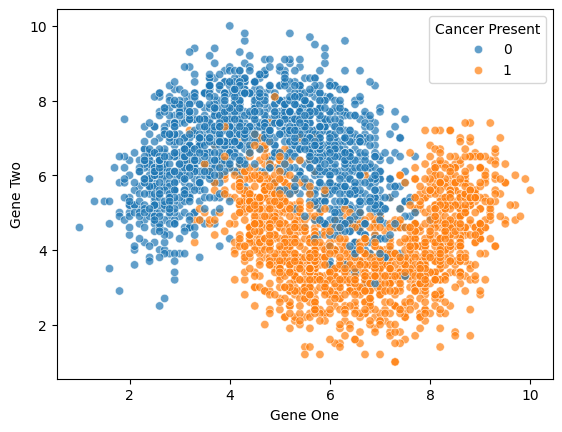

In [4]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df,alpha=0.7)

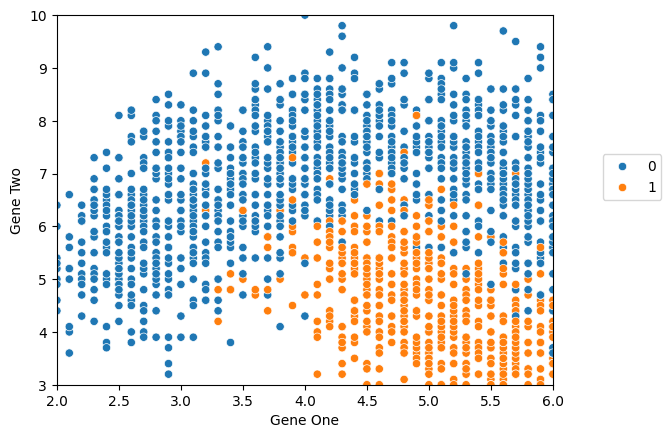

In [5]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df)
plt.xlim(2,6)
plt.ylim(3,10)
plt.legend(loc=(1.1,0.5));

## Разбиение на обучающий и тестовый наборы данных, а также масштабирование данных

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
scaler = StandardScaler()

In [11]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [14]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

# Интерпретация KNN  и выбор значения K

In [15]:
full_test = pd.concat([X_test,y_test],axis=1)

In [16]:
len(full_test)

900

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

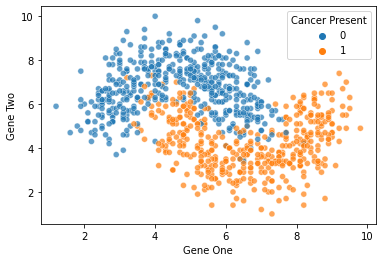

In [17]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',
                data=full_test,alpha=0.7)

## Оценка модели

In [18]:
y_pred = knn_model.predict(scaled_X_test)

In [19]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [20]:
accuracy_score(y_test,y_pred)

0.8922222222222222

In [21]:
confusion_matrix(y_test,y_pred)

array([[420,  50],
       [ 47, 383]], dtype=int64)

In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



## Метод локтя для выбора хороших значений K

**Замечание: здесь мы используем тестовый набор данных для выбора гиперпараметра K.**

In [23]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

Text(0.5, 0, 'K Value')

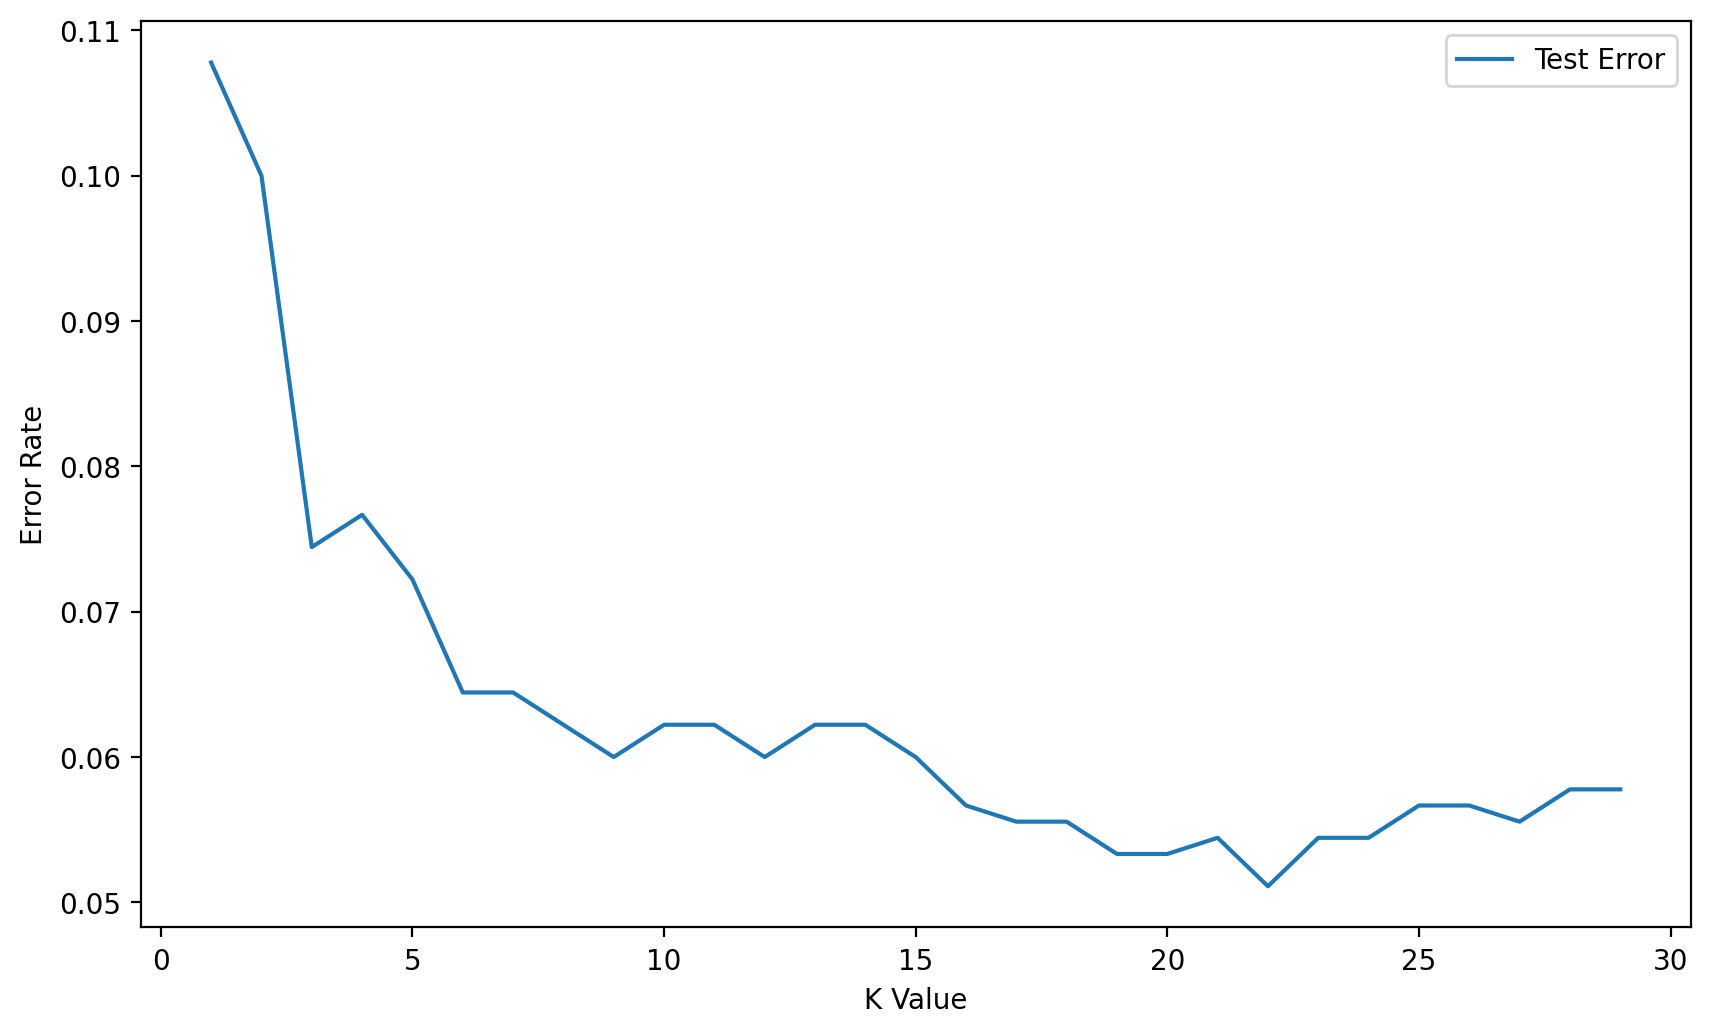

In [24]:
plt.figure(figsize=(10,6),dpi=200)
plt.plot(range(1,30),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")

## Кросс-валидация и поиск по сетке для значения K

### Создание пайплайна для поиска значения K

**Здесь будьте очень внимательны! Мы используем конкретные строковые коды И названия переменных, чтобы всё сделать правильно. Это не тот случай, когда можно легко менять названия переменных!**

Мы будем использовать объект Pipeline для настройки пайплайна из следующих операций:

1. Масштабирование данных
2. Создание модели на масштабируемых данных

----
*Как работает объект Scaler внутри Pipeline с кросс-валидацией (CV)? Является ли scikit-learn "достаточно умным", чтобы отдельно выполнить .fit() на обучающих данных, или выполнить .transform() на обучающих и тестовых данных?**

**Ответ - да! Пайплайны в Scikit-Learn отлично подходят для таких задач! [Дополнительные сведения можно почитать в документации](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling).**

Когда Вы применяете StandardScaler в качестве шага внутри Pipeline, то scikit-learn сделает всю нужную работу следующим образом:

* Шаг 0: Данные разбиваются на обучающий и тестовый наборы данных, в соответствии с параметром cv, который Вы указали в GridSearchCV.
* Шаг 1: объект scaler выбирает нужный масштаб на обучающем наборе данных
* Шаг 2: объект scaler трансформирует обучающий набор данных
* Шаг 3: выполняется обучение модели, используя трансформированный обучающий набор данных
* Шаг 4: объект scaler применяется для трансформации тестового набора данных
* Шаг 5: обученная модель выполняет предсказания, используя трансформированный тестовый набор данных

----

In [24]:
scaler = StandardScaler()

In [25]:
knn = KNeighborsClassifier()

In [26]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [27]:
# Очень рекомендуем использовать строковый код, который соответствует названию переменной!
operations = [('scaler',scaler),('knn',knn)]

In [28]:
from sklearn.pipeline import Pipeline

In [29]:
pipe = Pipeline(operations)

In [30]:
from sklearn.model_selection import GridSearchCV

---
*Замечание: Если ваша сетка из параметров будет помещаться внутри PipeLine, то название параметра следует указывать в следующем виде:**

* выбранное название строки + **два** нижних подчёркивания + название ключевого параметра
* название модели + __ + название параметра
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[Статья на StackOverflow по этой теме](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline).

Мы делаем это для того, чтобы scikit-learn знал, к какой операции пайплайна относятся эти параметры (иначе он может например подумать, что n_neighbors это параметр для scaler).

---

In [31]:
k_values = list(range(1,20))

In [32]:
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [33]:

param_grid = {'knn__n_neighbors': k_values}

In [34]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [35]:
# Используйте полные данные X и y, если Вы НЕ хотите отдельно отложить в сторону тестовый набор
# Используйте X_train и y_train, если Вы хотите отдельно отложить в сторону тестовый набор (X_test,y_test)
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [36]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=14))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=14),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 14,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [37]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Проверяем:
**сколько всего запусков мы сделали?**

In [38]:
len(k_values)

19

In [39]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.90238095, 0.90285714, 0.91857143, 0.91333333, 0.92380952,
       0.92142857, 0.9252381 , 0.9247619 , 0.9252381 , 0.92190476,
       0.9252381 , 0.9247619 , 0.92761905, 0.92904762, 0.92809524,
       0.92809524, 0.92904762, 0.92857143, 0.92761905])

In [40]:
len(full_cv_classifier.cv_results_['mean_test_score'])

19

## Финальная модель

Как мы увидели, метод GridSearch рекомендует значение K=14 (это соответствует методу локтя, если применить его). Давайте теперь снова применим PipeLine, но на этот раз нам не нужно выполнять поиск по сетке, вместо этого мы сделаем оценки на тестовом наборе данных.

In [41]:
scaler = StandardScaler()
knn14 = KNeighborsClassifier(n_neighbors=14)
operations = [('scaler',scaler),('knn14',knn14)]

In [42]:
pipe = Pipeline(operations)

In [43]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn14', KNeighborsClassifier(n_neighbors=14))])

In [44]:
pipe_pred = pipe.predict(X_test)

In [45]:
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [46]:
single_sample = X_test.iloc[40]

In [47]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [48]:
pipe.predict(single_sample.values.reshape(1, -1))

array([0], dtype=int64)

In [49]:
pipe.predict_proba(single_sample.values.reshape(1, -1))

array([[0.92857143, 0.07142857]])

----